🛋️ Sofa: [270, 75, 25]
🏢 Elevator: [238, 100, 215]
🚪 Door: [80, 215]


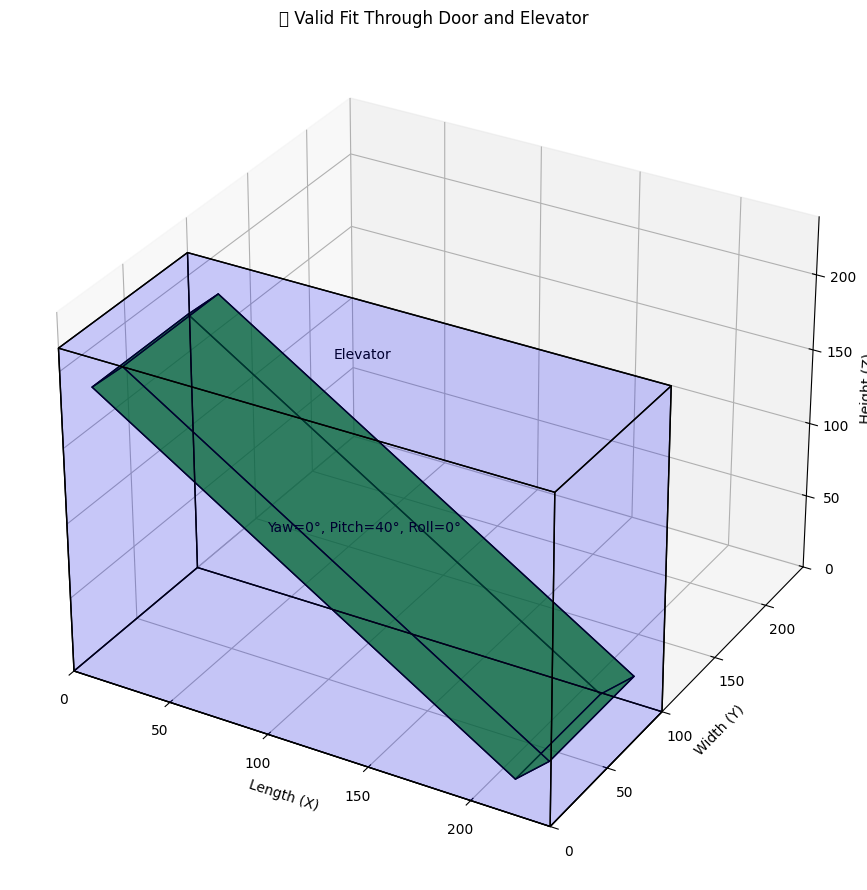

In [ ]:
# 📌 Enable inline plotting
%matplotlib inline

# 📌 Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.spatial.transform import Rotation as R
from itertools import product
import ipywidgets as widgets
from IPython.display import display

# 📌 Suppress font glyph warnings (optional)
import warnings
warnings.filterwarnings("ignore")


# 📌 Utility: Draw a 3D box in space
def draw_box(ax, origin, size, color, alpha=0.2, label=None):
    ox, oy, oz = origin
    l, w, h = size
    x = [ox, ox + l]
    y = [oy, oy + w]
    z = [oz, oz + h]

    vertices = [
        [x[0], y[0], z[0]],
        [x[1], y[0], z[0]],
        [x[1], y[1], z[0]],
        [x[0], y[1], z[0]],
        [x[0], y[0], z[1]],
        [x[1], y[0], z[1]],
        [x[1], y[1], z[1]],
        [x[0], y[1], z[1]],
    ]

    faces = [
        [vertices[0], vertices[1], vertices[2], vertices[3]],  # bottom
        [vertices[4], vertices[5], vertices[6], vertices[7]],  # top
        [vertices[0], vertices[1], vertices[5], vertices[4]],  # front
        [vertices[2], vertices[3], vertices[7], vertices[6]],  # back
        [vertices[1], vertices[2], vertices[6], vertices[5]],  # right
        [vertices[3], vertices[0], vertices[4], vertices[7]],  # left
    ]

    ax.add_collection3d(Poly3DCollection(faces, facecolors=color, edgecolors='black', alpha=alpha))

    if label:
        ax.text(ox + l / 2, oy + w / 2, oz + h + 5, label, color='black', ha='center')


# 📌 Check if all rotated corners are inside the elevator volume
def check_fit_in_elevator(corners, elevator_dims):
    corners = np.array(corners)
    return (
        (corners[:, 0] >= 0).all() and (corners[:, 0] <= elevator_dims[0]).all() and
        (corners[:, 1] >= 0).all() and (corners[:, 1] <= elevator_dims[1]).all() and
        (corners[:, 2] >= 0).all() and (corners[:, 2] <= elevator_dims[2]).all()
    )

# 📌 Check if projection of rotated box can pass through door opening (YZ projection)
def check_fit_through_door(rotated_corners, door_dims):
    projection = rotated_corners[:, [1, 2]]  # Project onto Y-Z plane
    min_corner = np.min(projection, axis=0)
    max_corner = np.max(projection, axis=0)
    width_required, height_required = max_corner - min_corner

    door_width, door_height = door_dims
    return width_required <= door_width and height_required <= door_height


# 📌 Main function to test and visualize
def find_valid_fit_with_door_constraint(box_small, box_large, door_dims):
    l, w, h = box_small
    corners = np.array([
        [0, 0, 0],
        [l, 0, 0],
        [l, w, 0],
        [0, w, 0],
        [0, 0, h],
        [l, 0, h],
        [l, w, h],
        [0, w, h]
    ])
    centroid = np.mean(corners, axis=0)
    corners_centered = corners - centroid

    best_fit = None
    # 🔁 Optimization: Use coarse 10° steps for fast testing
    for yaw, pitch, roll in product(range(0, 91, 10), repeat=3):
        rot = R.from_euler('zyx', [yaw, pitch, roll], degrees=True)
        rotated = rot.apply(corners_centered) + np.array(box_large) / 2

        if check_fit_in_elevator(rotated, box_large) and check_fit_through_door(rotated, door_dims):
            best_fit = (rotated, yaw, pitch, roll)
            break

    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')
    draw_box(ax, origin=(0, 0, 0), size=box_large, color='blue', alpha=0.1, label='Elevator')

    if best_fit:
        rotated_corners, yaw, pitch, roll = best_fit
        faces = [
            [0, 1, 2, 3],
            [4, 5, 6, 7],
            [0, 1, 5, 4],
            [2, 3, 7, 6],
            [1, 2, 6, 5],
            [3, 0, 4, 7]
        ]
        sofa_faces = [[rotated_corners[i] for i in face] for face in faces]
        ax.add_collection3d(Poly3DCollection(sofa_faces, facecolors='green', edgecolors='black', linewidths=1, alpha=0.5))
        ax.text(*np.mean(rotated_corners, axis=0), f"Yaw={yaw}°, Pitch={pitch}°, Roll={roll}°", color='black', ha='center')
        ax.set_title("✅ Valid Fit Through Door and Elevator")
    else:
        ax.set_title("❌ No Fit Found (Including Door Constraints)")

    ax.set_xlabel('Length (X)')
    ax.set_ylabel('Width (Y)')
    ax.set_zlabel('Height (Z)')
    max_range = max(box_large)
    ax.set_xlim(0, max_range)
    ax.set_ylim(0, max_range)
    ax.set_zlim(0, max_range)
    plt.tight_layout()
    plt.show()

    return best_fit is not None


# 📌 UI: Create interactive widgets for user input
sofa_length = widgets.IntSlider(value=270, min=50, max=400, step=5, description='Sofa Length:')
sofa_width = widgets.IntSlider(value=90, min=40, max=200, step=5, description='Sofa Width:')
sofa_height = widgets.IntSlider(value=50, min=5, max=150, step=5, description='Sofa Height:')

elevator_length = widgets.IntSlider(value=238, min=100, max=300, step=5, description='Elevator Len:')
elevator_width = widgets.IntSlider(value=100, min=80, max=200, step=5, description='Elevator Wid:')
elevator_height = widgets.IntSlider(value=215, min=150, max=300, step=5, description='Elevator Hei:')

door_width = widgets.IntSlider(value=100, min=60, max=150, step=5, description='Door Width:')
door_height = widgets.IntSlider(value=215, min=150, max=300, step=5, description='Door Height:')

run_button = widgets.Button(description="Run Fit Check")


# 📌 Callback function
def on_button_click(b):
    sofa = [sofa_length.value, sofa_width.value, sofa_height.value]
    elevator = [elevator_length.value, elevator_width.value, elevator_height.value]
    door = [door_width.value, door_height.value]

    print(f"🛋️ Sofa: {sofa}")
    print(f"🏢 Elevator: {elevator}")
    print(f"🚪 Door: {door}")
    find_valid_fit_with_door_constraint(sofa, elevator, door)


run_button.on_click(on_button_click)

# 📌 Display all widgets
display(
    widgets.VBox([
        widgets.HTML("<h3>📐 Sofa Dimensions</h3>"),
        sofa_length, sofa_width, sofa_height,
        widgets.HTML("<h3>📦 Elevator Interior Dimensions</h3>"),
        elevator_length, elevator_width, elevator_height,
        widgets.HTML("<h3>🚪 Elevator Door Dimensions</h3>"),
        door_width, door_height,
        run_button
    ])
)
